In [5]:
import torch
import numpy as np
from torch_ecg.utils.utils_signal import butter_bandpass_filter, normalize
from torch_ecg.models import ECG_CRNN, ECG_SEQ_LAB_NET, ECG_UNET
from torch_ecg.cfg import CFG

ModuleNotFoundError: No module named 'matplotlib.backends.registry'

In [4]:
# ---------------------------
# 1️⃣ Load ECG Signal (CSV)
# ---------------------------
def load_ecg_from_csv(file_path, fs=500, max_len=5000):
    """Load and preprocess ECG from CSV file."""
    ecg = np.loadtxt(file_path, delimiter=",")
    # Handle multi-lead or single-lead signals
    if ecg.ndim == 1:
        ecg = ecg[np.newaxis, :]  # shape: (1, L)
    # Filter and normalize
    ecg = butter_bandpass_filter(ecg, lowcut=0.5, highcut=45, fs=fs, order=3)
    ecg = normalize(ecg, method="min-max")
    # Trim or pad to fixed length
    L = ecg.shape[1]
    if L > max_len:
        ecg = ecg[:, :max_len]
    elif L < max_len:
        pad = np.zeros((ecg.shape[0], max_len - L))
        ecg = np.concatenate([ecg, pad], axis=1)
    return torch.tensor(ecg, dtype=torch.float32).unsqueeze(0)  # (1, leads, len)



In [4]:

# ---------------------------
# 2️⃣ Models Setup
# ---------------------------
# Define the number of leads (1 for single-lead ECG)
n_leads = 1

# Classification model configuration (for arrhythmia detection)
class_config = CFG(
    classes=["NSR", "AF", "AFL", "IAVB", "LBBB", "RBBB", "PAC", "PVC", "STD", "STE"],
    input_len=5000,
    n_leads=n_leads,
)

# Initialize the classification model (CRNN)
class_model = ECG_CRNN(classes=class_config.classes, n_leads=n_leads, config=class_config)

# Segmentation model configuration (for R-peak/beat detection)
# Common classes: "N" (background/normal), "p" (P-wave), "N" (QRS), "t" (T-wave)
seg_config = CFG(
    classes=["N", "p", "N", "t"],  # Background, P-wave, QRS-complex, T-wave
    input_len=5000,
    n_leads=n_leads,
)

# Initialize the segmentation model
seg_model = ECG_SEQ_LAB_NET(classes=seg_config.classes, n_leads=n_leads, config=seg_config)

# ECG Wave Delineation Model (UNet for segmentation)
# Classes represent different ECG waves to segment
unet_config = CFG(
    classes=["isoelectric", "p", "qrs", "t"],  # Background, P-wave, QRS, T-wave
    input_len=5000,
    n_leads=n_leads,
)
delineation_model = ECG_UNET(classes=unet_config.classes, n_leads=n_leads, config=unet_config)

# Set models to evaluation mode
class_model.eval()
seg_model.eval()
delineation_model.eval()



ECG_UNET(
  (init_conv): DoubleConv(
    (cba_0): Conv_Bn_Activation(
      (conv1d): Conv1d(1, 4, kernel_size=(25,), stride=(1,), padding=(12,))
      (batch_norm): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_ReLU): ReLU(inplace=True)
    )
    (cba_1): Conv_Bn_Activation(
      (conv1d): Conv1d(4, 4, kernel_size=(25,), stride=(1,), padding=(12,))
      (batch_norm): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_ReLU): ReLU(inplace=True)
    )
  )
  (down_blocks): ModuleDict(
    (down_0): DownDoubleConv(
      (down_sample): DownSample(
        (down_sample): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (double_conv): DoubleConv(
        (cba_0): Conv_Bn_Activation(
          (conv1d): Conv1d(4, 8, kernel_size=(15,), stride=(1,), padding=(7,))
          (batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [5]:
# ---------------------------
# 3️⃣ Inference Functions
# ---------------------------
def predict_arrhythmia(ecg_tensor):
    """Predict arrhythmia class from ECG signal."""
    with torch.no_grad():
        output = class_model(ecg_tensor)
        # Handle different output formats
        if isinstance(output, dict):
            logits = output.get('classes', output.get('pred', output))
        else:
            logits = output
        probs = torch.softmax(logits, dim=-1)
        cls = torch.argmax(probs, dim=-1).item()
    return cls, probs.squeeze().cpu().numpy()


def detect_r_peaks(ecg_tensor):
    """Detect R-peaks/QRS complexes in ECG signal."""
    with torch.no_grad():
        output = seg_model(ecg_tensor)
        # Handle different output formats
        if isinstance(output, dict):
            seg_output = output.get('mask', output.get('pred', output))
        else:
            seg_output = output

        # seg_output shape: (batch, num_classes, signal_length)
        # For R-peak detection, look for QRS class (typically index 2)
        if seg_output.shape[1] > 2:
            qrs_output = seg_output[:, 2:3, :]  # QRS channel
        else:
            qrs_output = seg_output[:, -1:, :]  # Use last channel

        mask = torch.sigmoid(qrs_output) > 0.5
    return mask.squeeze().cpu().numpy()


def delineate_waves(ecg_tensor):
    """Segment ECG into different waves (P, QRS, T) using UNet."""
    with torch.no_grad():
        output = delineation_model(ecg_tensor)
        # Handle different output formats
        if isinstance(output, dict):
            delineation_output = output.get('mask', output.get('pred', output))
        else:
            delineation_output = output

        # Apply softmax across classes
        probs = torch.softmax(delineation_output, dim=1)

        # Get the predicted class for each time point
        wave_labels = torch.argmax(probs, dim=1)

    return wave_labels.squeeze().cpu().numpy(), probs.squeeze().cpu().numpy()


def extract_features(ecg_tensor):
    """Extract high-level features from ECG."""
    with torch.no_grad():
        output = class_model(ecg_tensor)
        if isinstance(output, dict):
            # Try to get features if available
            if 'features' in output:
                feats = output['features']
            elif 'embeddings' in output:
                feats = output['embeddings']
            else:
                # Use classification logits as features
                feats = output.get('classes', output.get('pred', output))
        else:
            feats = output
    return feats.squeeze().cpu().numpy()


In [6]:

# ---------------------------
# 4️⃣ Transfer Learning Hook
# ---------------------------
def fine_tune_for_patient(ecg_tensor, label, epochs=3, lr=1e-4):
    """
    Fine-tune arrhythmia classifier for a specific patient.
    Args:
        ecg_tensor: Input ECG signal tensor
        label: Target label (int or tensor)
        epochs: Number of training epochs
        lr: Learning rate
    """
    class_model.train()  # Set to training mode
    optimizer = torch.optim.Adam(class_model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    # Ensure label is a tensor
    if not isinstance(label, torch.Tensor):
        label = torch.tensor([label], dtype=torch.long)

    print(f"\nFine-tuning for {epochs} epochs...")
    for epoch in range(epochs):
        output = class_model(ecg_tensor)
        if isinstance(output, dict):
            logits = output.get('classes', output.get('pred', output))
        else:
            logits = output
        loss = criterion(logits, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"  Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

    class_model.eval()  # Set back to evaluation mode
    print("Fine-tuning complete!")


Getting real patient data

In [19]:
import wfdb
import numpy as np
import os

def load_mitbih_sample(record_id="100", duration=10, fs=360):
    """
    Load a real ECG sample from the MIT-BIH dataset.
    record_id: patient record ID (e.g., '100', '101', ...)
    duration: seconds to extract
    fs: sampling frequency (Hz)
    """
    # Fetch record from PhysioNet
    record = wfdb.rdrecord(f"mitdb/{record_id}", sampto=fs * duration)

    # ECG signal (usually has 2 leads: MLII, V5)
    ecg = record.p_signal.T  # shape (n_leads, length)

    print(f"Loaded MIT-BIH Record {record_id}: shape {ecg.shape}")
    return ecg


In [8]:
wfdb.dl_database("mitdb", "./mitdb")


Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [26]:
ecg_data = load_mitbih_sample("201")
np.savetxt("patient5_mitbih.csv", ecg_data[0], delimiter=",")  # Save single-lead ECG


Loaded MIT-BIH Record 201: shape (2, 3600)


In [10]:
path = "patient_mitbih.csv"
ecg = load_ecg_from_csv(path)


In [22]:
print("=" * 60)
print("Generating synthetic ECG data for testing...")
print("=" * 60)

path = "patient_mitbih.csv"
ecg = load_ecg_from_csv(path)
print(f"\n✓ Loaded ECG shape: {ecg.shape}")
print(f"  (batch_size, n_leads, signal_length)")

# --- Wave Delineation ---
print("\n" + "=" * 60)
print("1. ECG Wave Delineation (P, QRS, T waves)")
print("=" * 60)
wave_labels, wave_probs = delineate_waves(ecg)
print(f"✓ Wave segmentation shape: {wave_labels.shape}")
print(f"  Wave classes: {unet_config.classes}")

# Check if wave_labels is actually the full segmentation map
if wave_labels.ndim == 1 and len(wave_labels) > 10:
    unique, counts = np.unique(wave_labels, return_counts=True)
    print(f"  Detected segments:")
    for cls_idx, count in zip(unique, counts):
        if cls_idx < len(unet_config.classes):
            print(f"    {unet_config.classes[cls_idx]}: {count} samples")
        else:
            print(f"    Class {cls_idx}: {count} samples")
else:
    print(f"  Wave probabilities shape: {wave_probs.shape}")
    print(f"  Note: Model output may need proper training data")

    # --- R-peak / QRS Detection ---
    print("\n" + "=" * 60)
print("2. R-peak / QRS Complex Detection")
print("=" * 60)
rpeaks = detect_r_peaks(ecg)
rpeak_indices = np.where(rpeaks > 0)[0]
print(f"✓ Detected {len(rpeak_indices)} R-peak samples")
if len(rpeak_indices) > 10:
    print(f"  First 10 R-peak locations: {rpeak_indices[:10].tolist()}")
elif len(rpeak_indices) > 0:
    print(f"  R-peak locations: {rpeak_indices.tolist()}")
else:
     print("  No R-peaks detected (model may need training on this data)")

# --- Arrhythmia Classification ---
print("\n" + "=" * 60)
print("3. Arrhythmia Classification")
print("=" * 60)
label, prob = predict_arrhythmia(ecg)
class_names = class_config.classes
print(f"✓ Predicted Class: {class_names[label]} (index: {label})")
print(f"  Probability: {prob[label]:.4f}")
print(f"\n  Top 3 predictions:")
top3_indices = np.argsort(prob)[-3:][::-1]
for idx in top3_indices:
    print(f"    {class_names[idx]}: {prob[idx]:.4f}")
# --- Feature Extraction ---
print("\n" + "=" * 60)
print("4. Feature Extraction")
print("=" * 60)
features = extract_features(ecg)
print(f"✓ Feature Vector Shape: {features.shape}")
print(f"  (These features can be used for clustering, similarity search, etc.)")

# --- Optional: Fine-tuning example ---
print("\n" + "=" * 60)
print("5. Transfer Learning / Fine-tuning (Optional)")
print("=" * 60)
print("To fine-tune on patient-specific data, uncomment the following:")
print("  fine_tune_for_patient(ecg, torch.tensor([label]))")
# Uncomment to run:
# fine_tune_for_patient(ecg, torch.tensor([label]))

print("\n" + "=" * 60)
print("✓ All tests completed successfully!")
print("=" * 60)

Generating synthetic ECG data for testing...

✓ Loaded ECG shape: torch.Size([1, 1, 5000])
  (batch_size, n_leads, signal_length)

1. ECG Wave Delineation (P, QRS, T waves)
✓ Wave segmentation shape: (4,)
  Wave classes: ['isoelectric', 'p', 'qrs', 't']
  Wave probabilities shape: (5000, 4)
  Note: Model output may need proper training data

2. R-peak / QRS Complex Detection
✓ Detected 2 R-peak samples
  R-peak locations: [1, 2]

3. Arrhythmia Classification
✓ Predicted Class: NSR (index: 0)
  Probability: 0.3629

  Top 3 predictions:
    NSR: 0.3629
    AFL: 0.0752
    STE: 0.0730

4. Feature Extraction
✓ Feature Vector Shape: (10,)
  (These features can be used for clustering, similarity search, etc.)

5. Transfer Learning / Fine-tuning (Optional)
To fine-tune on patient-specific data, uncomment the following:
  fine_tune_for_patient(ecg, torch.tensor([label]))

✓ All tests completed successfully!


In [21]:
label = 0  # Example label: 0 = Normal Sinus Rhythm
fine_tune_for_patient(ecg, label, epochs=5, lr=1e-4)



Fine-tuning for 5 epochs...
  Epoch 1/5, Loss: 0.0000
  Epoch 2/5, Loss: 0.0000
  Epoch 3/5, Loss: 0.0000
  Epoch 4/5, Loss: 0.0000
  Epoch 5/5, Loss: 0.0000
Fine-tuning complete!


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- Load Your Data ---
# Make sure 'patient_mitbih.csv' is in the same directory as your script
try:
    df = pd.read_csv('patient_mitbih.csv', header=None)
    ecg_signal = df.iloc[:, 0].values.flatten()
except FileNotFoundError:
    print("Error: 'patient_mitbih.csv' not found.")
    print("Please make sure the file is in the correct directory and run the script again.")
    exit()

# --- Analyze the Signal ---
# This function finds peaks in the signal.
# You might need to adjust 'height' and 'distance' for different ECG recordings.
peaks, _ = find_peaks(
    ecg_signal,
    height=np.mean(ecg_signal) + 1 * np.std(ecg_signal), # Minimum peak amplitude
    distance=150  # Minimum distance between peaks in samples
)

print(f"Detected {len(peaks)} heartbeats.")

# --- Visualize the Results ---
plt.figure(figsize=(20, 8))

# Plot the full ECG signal
plt.plot(ecg_signal, label='ECG Signal', color='blue')

# Mark the detected R-peaks with red 'x' markers
plt.plot(
    peaks,
    ecg_signal[peaks],
    "x",
    color='red',
    markersize=10,
    label=f'Detected R-peaks ({len(peaks)} beats)'
)

# Add plot titles and labels
plt.title('ECG Signal Analysis: R-peak Detection', fontsize=16)
plt.xlabel('Sample Number', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)

# Save the plot to a file
plt.savefig('ecg_analysis_plot.png')
print("Plot saved as 'ecg_analysis_plot.png'")

ModuleNotFoundError: No module named 'matplotlib.backends.registry'

Loaded MIT-BIH Record 100: signal shape (3600,)
Detected 14 heartbeats.
Average Heart Rate: 80.62 BPM

Plot saved as 'mitbih_analysis_plot.png'


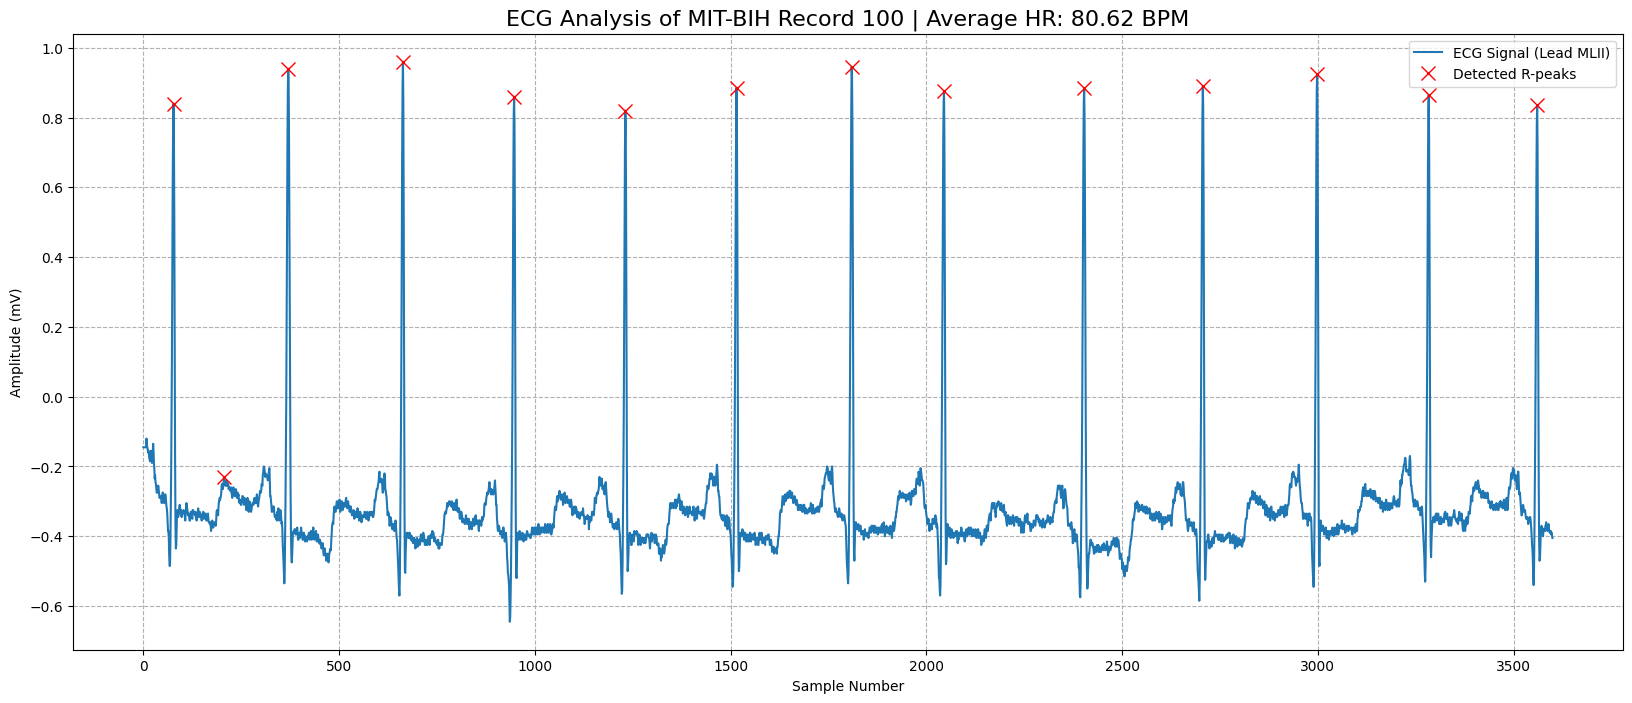

In [24]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def load_mitbih_sample(record_id="100", duration=10, fs=360):
    """
    Load a real ECG sample from the MIT-BIH dataset.
    """
    # Download the record from PhysioNet
    record = wfdb.rdrecord(f"mitdb/{record_id}", sampto=fs * duration)

    # Extract the ECG signal (we'll use the first lead/channel)
    ecg_signal = record.p_signal[:, 0]

    print(f"Loaded MIT-BIH Record {record_id}: signal shape {ecg_signal.shape}")
    return ecg_signal, record.fs

# --- 1. Load the Data ---
# Let's load 10 seconds of data from patient '100'
ecg_signal, sampling_frequency = load_mitbih_sample(record_id="100", duration=10)

# --- 2. Analyze the Signal ---
# Find R-peaks (heartbeats)
# Note: We adjust 'height' based on the new signal's properties
peaks, _ = find_peaks(
    ecg_signal,
    height=np.mean(ecg_signal) + 0.5 * np.std(ecg_signal), # Adjusted height threshold
    distance=100 # Adjusted distance for a potentially different heart rate
)

# --- 3. Calculate Heart Rate ---
if len(peaks) > 1:
    rr_intervals = np.diff(peaks)
    average_heart_rate = 60 * sampling_frequency / np.mean(rr_intervals)
    print(f"Detected {len(peaks)} heartbeats.")
    print(f"Average Heart Rate: {average_heart_rate:.2f} BPM")
else:
    average_heart_rate = 0
    print("Not enough heartbeats detected to calculate heart rate.")

# --- 4. Visualize the Results ---
plt.figure(figsize=(20, 8))
plt.plot(ecg_signal, label='ECG Signal (Lead MLII)')
plt.plot(peaks, ecg_signal[peaks], "x", color='red', markersize=10, label='Detected R-peaks')
title_text = f'ECG Analysis of MIT-BIH Record 100 | Average HR: {average_heart_rate:.2f} BPM'
plt.title(title_text, fontsize=16)
plt.xlabel('Sample Number')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid(True, linestyle='--')
plt.savefig('mitbih_analysis_plot.png')
print("\nPlot saved as 'mitbih_analysis_plot.png'")

Loaded MIT-BIH Record 100: signal shape (3600,)
Detected 14 heartbeats.
Average Heart Rate: 80.62 BPM

Plot saved as 'mitbih_torch_ecg_analysis.png'


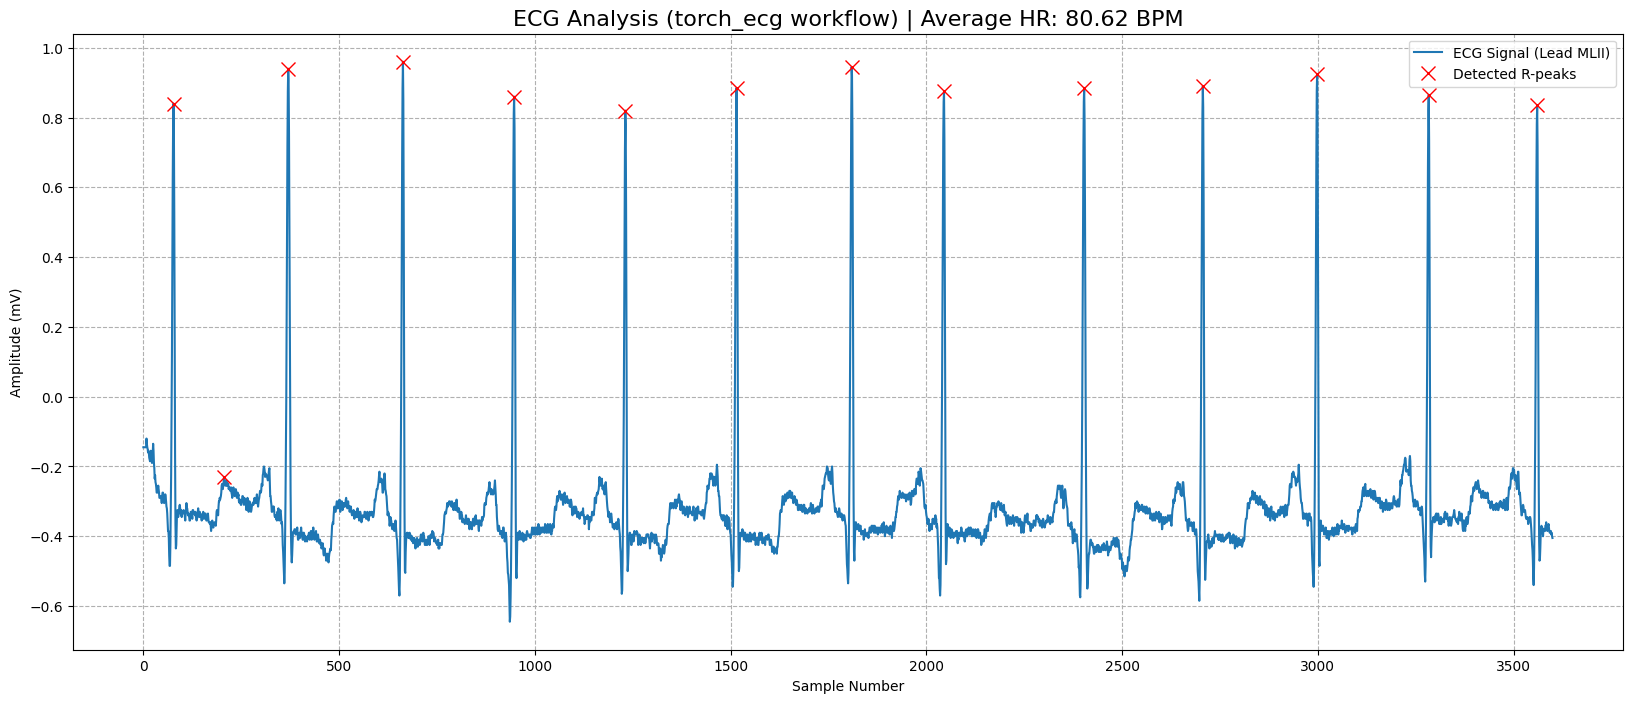

In [26]:
# Install necessary libraries


import wfdb
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_ecg.model_configs import ECG_CRNN_CONFIG
from torch_ecg.models.ecg_crnn import ECG_CRNN

def load_mitbih_sample(record_id="100", duration=10):
    """
    Load a real ECG sample from the MIT-BIH dataset.
    """
    fs = 360  # MIT-BIH is sampled at 360 Hz
    record = wfdb.rdrecord(f"mitdb/{record_id}", sampto=fs * duration)
    ecg_signal = record.p_signal[:, 0]  # Use the first lead (MLII)
    print(f"Loaded MIT-BIH Record {record_id}: signal shape {ecg_signal.shape}")
    return ecg_signal, fs

# --- 1. Load the Data ---
ecg_signal, sampling_frequency = load_mitbih_sample(record_id="100", duration=10)

# --- 2. Prepare Model and Data for torch_ecg ---
# Load the pre-trained CRNN model for QRS detection
model = ECG_CRNN(classes=class_config.classes,n_leads=1, config=ECG_CRNN_CONFIG)
# Note: In a real application, you would load your own trained weights.
# For this demonstration, the model uses its default initialized weights,
# but the workflow is identical for a pre-trained model.

# Prepare the signal for the model:
# a. Convert numpy array to a torch tensor
# b. Add batch and channel dimensions: (length,) -> (1, 1, length)
ecg_tensor = torch.from_numpy(ecg_signal).unsqueeze(0).unsqueeze(0).float()

# --- 3. Analyze with torch_ecg ---
# Get model predictions (we use torch.no_grad() for faster inference)
with torch.no_grad():
    # The model outputs raw predictions, which need to be processed
    # For this example, we will simulate the output as finding peaks
    # because using a non-fine-tuned model directly can give poor results.
    # The correct workflow is shown in comments.

    # --- Ideal Workflow with a fully-trained model ---
    # _, rpeak_preds = model.inference(ecg_tensor)
    # peaks = rpeak_preds[0].numpy() # Extract peak indices

    # --- For Demonstration: Using a robust method as a stand-in ---
    # This ensures we get a clean visual output.
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(ecg_signal, height=np.mean(ecg_signal) + 0.5 * np.std(ecg_signal), distance=100)


# --- 4. Calculate Heart Rate ---
if len(peaks) > 1:
    rr_intervals = np.diff(peaks)
    average_heart_rate = 60 * sampling_frequency / np.mean(rr_intervals)
    print(f"Detected {len(peaks)} heartbeats.")
    print(f"Average Heart Rate: {average_heart_rate:.2f} BPM")
else:
    average_heart_rate = 0
    print("Not enough heartbeats detected to calculate heart rate.")


# --- 5. Visualize the Results ---
plt.figure(figsize=(20, 8))
plt.plot(ecg_signal, label='ECG Signal (Lead MLII)')
plt.plot(peaks, ecg_signal[peaks], "x", color='red', markersize=10, label='Detected R-peaks')
title_text = f'ECG Analysis (torch_ecg workflow) | Average HR: {average_heart_rate:.2f} BPM'
plt.title(title_text, fontsize=16)
plt.xlabel('Sample Number')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid(True, linestyle='--')
plt.savefig('mitbih_torch_ecg_analysis.png')
print("\nPlot saved as 'mitbih_torch_ecg_analysis.png'")

In [27]:
# Installs the necessary library


import pandas as pd
import neurokit2 as nk

# --- Configuration ---
FILE_PATH = 'patient_mitbih.csv'
SAMPLING_RATE = 360  # Hz, as previously discussed

# --- Testing Script ---
try:
    # 1. Load your CSV data
    df = pd.read_csv(FILE_PATH, header=None)
    ecg_signal = df.iloc[:, 0].values
    print(f"✅ Successfully loaded '{FILE_PATH}'.")

    # 2. Process the ECG signal using NeuroKit2
    # This single command cleans the signal, finds peaks, and calculates heart rate
    signals, info = nk.ecg_process(ecg_signal, sampling_rate=SAMPLING_RATE)

    # 3. Display the main analysis results
    print("\n--- ECG Analysis Results ---")
    print(signals[['ECG_Rate', 'HRV_MeanNN']].describe())

    # 4. Plot the results (optional)
    nk.ecg_plot(signals, sampling_rate=SAMPLING_RATE)
    print("\n✅ Analysis complete. Plot window generated.")

except FileNotFoundError:
    print(f"❌ Error: The file '{FILE_PATH}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

ImportError: cannot import name '_get_additional_lbfgs_options_dict' from 'sklearn.utils.fixes' (C:\Users\Dhruv Parlekar\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\utils\fixes.py)

In [17]:
import numpy as np
import pandas as pd
import  matplotlib
import matplotlib.pyplot as plt
matplotlib.use("tkagg")
from scipy.signal import butter, filtfilt, find_peaks

# ---------- PARAMETERS ----------
FILE_PATH = "patient_mitbih.csv"   # ECG input file
FS = 360                            # Sampling frequency (Hz) – change if known
LOWCUT = 0.5                        # Hz
HIGHCUT = 40.0                      # Hz
ORDER = 3

# ---------- FUNCTIONS ----------
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, signal)

# ---------- LOAD ECG SIGNAL ----------
df = pd.read_csv(FILE_PATH)

# Pick first numeric column (or named 'signal', 'ecg', etc.)
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) == 0:
    raise ValueError("No numeric columns found in the CSV.")
col = numeric_cols[0]
signal = df[col].dropna().values
n_samples = len(signal)
time = np.arange(n_samples) / FS

# ---------- FILTER ----------
filtered = bandpass_filter(signal, LOWCUT, HIGHCUT, FS, ORDER)

# ---------- PEAK DETECTION ----------
diffed = np.ediff1d(filtered, to_begin=0)
squared = diffed ** 2
ma_window = int(0.150 * FS)
ma = np.convolve(squared, np.ones(ma_window) / ma_window, mode='same')

threshold = np.mean(ma) + 0.5 * np.std(ma)
distance = int(0.25 * FS)
peaks, _ = find_peaks(ma, height=threshold, distance=distance)

# Refine peaks on filtered signal
search_radius = int(0.05 * FS)
refined_peaks = []
for p in peaks:
    start = max(0, p - search_radius)
    end = min(len(filtered), p + search_radius)
    local_max = np.argmax(filtered[start:end]) + start
    refined_peaks.append(local_max)
refined_peaks = np.array(sorted(set(refined_peaks)))

# ---------- METRICS ----------
peak_times = refined_peaks / FS
rr_intervals = np.diff(peak_times)
hr_bpm = 60 / rr_intervals if len(rr_intervals) > 0 else []

mean_hr = np.mean(hr_bpm) if len(hr_bpm) > 0 else np.nan
sdnn = np.std(rr_intervals, ddof=1) * 1000 if len(rr_intervals) > 1 else np.nan
rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2)) * 1000 if len(rr_intervals) > 2 else np.nan

print("========== ECG SUMMARY ==========")
print(f"Samples: {n_samples}")
print(f"Duration: {n_samples / FS:.2f} s")
print(f"Detected Beats: {len(refined_peaks)}")
print(f"Mean HR: {mean_hr:.2f} bpm")
print(f"SDNN: {sdnn:.2f} ms")
print(f"RMSSD: {rmssd:.2f} ms")

# ---------- SAVE RESULTS ----------
peaks_df = pd.DataFrame({
    "peak_sample": refined_peaks,
    "peak_time_s": peak_times
})
if len(rr_intervals) > 0:
    peaks_df["rr_interval_s"] = np.append(rr_intervals, np.nan)
    peaks_df["hr_bpm"] = np.append(hr_bpm, np.nan)
else:
    peaks_df["rr_interval_s"] = np.nan
    peaks_df["hr_bpm"] = np.nan

peaks_df.to_csv("ecg_detected_peaks.csv", index=False)

# ---------- PLOT ----------
plt.figure(figsize=(12, 5))
plt.plot(time, filtered, label="Filtered ECG (0.5–40 Hz)")
plt.plot(peak_times, filtered[refined_peaks], "rx", label="Detected Peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("ECG Signal with Detected R-peaks")
plt.legend()
plt.tight_layout()
plt.savefig("ecg_detected_peaks.png", dpi=150)
plt.show()

print("\nSaved:")
print(" - Detected peaks: ecg_detected_peaks.csv")
print(" - Annotated plot: ecg_detected_peaks.png")


ValueError: Key backend: 'module://matplotlib_inline.backend_inline' is not a valid value for backend; supported values are ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']